<a href="https://colab.research.google.com/github/soumyadipghorai/Timeseries-analysis-dogecoin/blob/main/Doge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import 

In [2]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5 MB 7.9 MB/s 
     |████████████████████████████████| 9.5 MB 20.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36084 sha256=8fffb6f82f69051aa471d82f7c5eb0e52489c4d53f9ffe210273e12593de482a
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score
import datetime
from wordcloud import WordCloud

In [5]:
# import dataset
df = pd.read_csv('Dogecoin_June.csv')

# function to join 
def join(arr) : 
    ans = ''
    for i in arr : 
        ans += i 
    return ans 

# rename column 
df = df.rename( 
    columns={
            "Open*" : "Open",
            "Close**" : "Close", 
            "Market Cap" : "Market_Cap" 
        }
    )

# cleaning values
for i in range(len(df)) : 
    df.Close[i] = df.Close[i][1:]
    df.Volume[i] = df.Volume[i][1:]
    df.Market_Cap[i] = df.Market_Cap[i][1:]
    if df.High[i][0] == "$" : 
        df.High[i] = df.High[i][1:]
    if df.Open[i][0] == "$" : 
        df.Open[i] = df.Open[i][1:]
    if df.Low[i][0] == "$" : 
        df.Low[i] = df.Low[i][1:]
    volume_series = df.Volume.str.split(',')    
    Market_Cap_series = df.Market_Cap.str.split(',')
    df.Volume[i] = join(volume_series[i])
    df.Market_Cap[i] = join(Market_Cap_series[i])

# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2768 non-null   object
 1   Open        2768 non-null   object
 2   High        2768 non-null   object
 3   Low         2768 non-null   object
 4   Close       2768 non-null   object
 5   Volume      2768 non-null   object
 6   Market_Cap  2768 non-null   object
dtypes: object(7)
memory usage: 151.5+ KB


In [6]:
# fixing data type 
df.Date = pd.to_datetime(df.Date)
df.Open = df.Open.astype(float)
df.High = df.High.astype(float)
df.Low = df.Low.astype(float)
df.Close = df.Close.astype(float)
df.Volume = df.Volume.astype(int)
df.Market_Cap = df.Market_Cap.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2768 non-null   datetime64[ns]
 1   Open        2768 non-null   float64       
 2   High        2768 non-null   float64       
 3   Low         2768 non-null   float64       
 4   Close       2768 non-null   float64       
 5   Volume      2768 non-null   int64         
 6   Market_Cap  2768 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 151.5 KB


In [7]:
# addign new col 
market_mode, market_change, jump, price, quantity = [], [], [], [], []

for i in range(len(df)) : 
    if df.Open[i] < df.Close[i] : 
        market_mode.append("positive")
    else : 
        market_mode.append("negative")

    market_change_val = ((df.Close[i] - df.Open[i])/df.Open[i])*100
    market_change.append('%.2f'%market_change_val)

    jump_val = ((df.High[i] - df.Low[i])/df.Low[i])*100
    jump.append('%.2f'%jump_val)

    price_val = (df.High[i] + df.Low[i])/2
    price.append(price_val)

df["Price"] = price
df["market_mode"] = market_mode
df["market_change(%)"] = market_change
df["jump(%)"] = jump

for i in range(len(df)) : 
    quantity_val = int(df.Volume[i]/df.Price[i])
    quantity.append(quantity_val)

df["Quantity"] = quantity

df["market_change(%)"] = df["market_change(%)"].astype(float)
df["jump(%)"] = df["jump(%)"].astype(float)
df.Price = df.Price.astype(float)

df

,Date,Open,High,Low,Close,Volume,Market_Cap,Price,market_mode,market_change(%),jump(%),Quantity
0,2021-07-13,0.208000,0.208100,0.198200,0.200000,1035890377,26085611532,0.203150,negative,-3.85,4.99,5099140423
1,2021-07-12,0.216000,0.219000,0.204500,0.208000,973602708,27131951860,0.211750,negative,-3.70,7.09,4597887641
2,2021-07-11,0.213900,0.218700,0.210900,0.215900,719870047,28147268916,0.214800,positive,0.94,3.70,3351350311
3,2021-07-10,0.219800,0.227700,0.210700,0.213900,1264519098,27891519500,0.219200,negative,-2.68,8.07,5768791505
4,2021-07-09,0.207100,0.229100,0.196600,0.219900,3045790264,28663595549,0.212850,positive,6.18,16.53,14309561963
...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2013-12-19,0.000395,0.001520,0.000328,0.001162,0,11150339,0.000924,positive,194.10,362.99,0
2764,2013-12-18,0.000267,0.000362,0.000205,0.000362,0,3188943,0.000283,positive,35.28,76.74,0
2765,2013-12-17,0.000207,0.000289,0.000116,0.000269,0,2169688,0.000202,positive,29.77,149.83,0
2766,2013-12-16,0.000299,0.000866,0.000150,0.000205,0,1509085,0.000508,negative,-31.61,476.50,0


## Descriptive

In [8]:
# plot update function
def update_layout(title, xaxis_title, yaxis_title, legend_title = None, xgrid = False, ygrid = True) : 

    fig.update_layout(
        title={
                'text' : title,
                'y':0.95,
                'x':0.5
            },
        font_family="Palatino",
        title_font_family="Times New Roman",
        title_font_color="#2e2c61",    
        title_font_size = 22,       
        xaxis_title= xaxis_title,
        yaxis_title= yaxis_title,
        font_color="#262424",
        paper_bgcolor='white',
        plot_bgcolor='white',
        )

    try : 
        fig.update_layout(
            legend_title = legend_title,
            legend_title_font_color="green"
        )
    except : 
        pass
    if xgrid == True : 
        if ygrid == False :
            fig.update_xaxes(showline=True, linewidth=2, 
                            linecolor='#626969', showgrid=True, gridcolor = "#c2c2c2")
        else : 
            fig.update_xaxes(showline=True, linewidth=2,
                            linecolor='#626969', showgrid=True, gridcolor = "#c2c2c2")
            fig.update_yaxes(showline=True, linewidth=2,
                            linecolor='#626969', showgrid=True, gridcolor = "#c2c2c2")
    else : 
        fig.update_xaxes(showline=True, linewidth=2,
                        linecolor='#626969', showgrid=False)
        fig.update_yaxes(showline=True, linewidth=2,
                        linecolor='#626969', showgrid=True, gridcolor = "#c2c2c2")

    fig.show()

In [9]:
fig = px.line(df, x = "Date", y ="Price")
update_layout("Date vs Price", "Date", "Price", True)

In [10]:
fig = px.scatter(df, x = "Date", y = "Price")
update_layout("Date vs Price scatter plot", "Date", "Price")

In [11]:
dff = df.head(365)

fig = go.Figure(data=[go.Scatter( 
            x = dff.Date, 
            y = dff["Price"],
            name = "Price"),            
                           go.Scatter( 
            x = dff.Date, 
            y = dff["High"],
            name = 'High'),

            go.Scatter( 
            x = dff.Date, 
            y = dff["Low"],
            name = "Low")
        ]);
update_layout("Price lies between High and Low", "Date", "Price")

In [12]:
dff = df.head(365)

fig = go.Figure(data=[go.Scatter( 
            x = dff.Date, 
            y = dff["Price"],
            name = "Price"),           
    
            go.Scatter(
            x = dff.Date, 
            y = dff["Open"],
            name = 'Open'),

            go.Scatter( 
            x = dff.Date, 
            y = dff["Close"],
            name = "close")
        ]);

update_layout("Price and Open-Close in the market", "Date", "Price")

In [13]:
fig = px.line(df, x = "Date", y ="Volume")
update_layout("Trade volumes of different dates", "Date", "Volume ($)")

In [14]:
fig = px.line(df, x = "Date", y ="Market_Cap")
update_layout("Market cap changes", "Date", "Market cap ($)")

## Moving average 

In [15]:
# A moving average, also called a rolling or running average, is used to analyze the time-series data by calculating averages of different subsets of the complete dataset. Since it involves taking the average of the dataset over time, it is also called a moving mean (MM) or rolling mean.
moving3 = df.Price.rolling(window= 3).mean()
moving7 = df.Price.rolling(window= 7).mean()
moving30 = df.Price.rolling(window= 30).mean()

moving_df = pd.DataFrame(moving3)
moving_df = moving_df.rename( columns = {
    "Price" : "3day"
})
moving_df["7day"] = moving7
moving_df["30day"] = moving30
moving_df["Date"] = df.Date
moving_df["Price"] = df.Price
moving_df.dropna(inplace = True)
moving_df

,3day,7day,30day,Date,Price
29,0.284067,0.288586,0.246338,2021-06-14,0.215000
30,0.286250,0.295286,0.250233,2021-06-13,0.320000
31,0.281667,0.297857,0.253508,2021-06-12,0.310000
32,0.316667,0.301550,0.257015,2021-06-11,0.320000
33,0.320000,0.304600,0.260708,2021-06-10,0.330000
...,...,...,...,...,...
2763,0.000785,0.000632,0.000434,2013-12-19,0.000924
2764,0.000703,0.000583,0.000430,2013-12-18,0.000283
2765,0.000470,0.000515,0.000423,2013-12-17,0.000202
2766,0.000331,0.000534,0.000427,2013-12-16,0.000508


In [16]:
fig = px.line(moving_df.head(1000), x = "Date", y = "30day")
update_layout("30 day moving avg price scatter plot", "Date", "Price")

In [17]:
moving_df = moving_df.head(150)
fig = go.Figure(data=[go.Scatter( 
            x = moving_df.Date, 
            y = moving_df["7day"],
            name = "7day moving avg"),           
    
            go.Scatter(
            x = moving_df.Date, 
            y = moving_df['3day'],
            name = '3day moving avg'),

            go.Scatter(
            x = moving_df.Date, 
            y = moving_df['Price'],
            name = 'Actual Price')
        ]);
update_layout("7 day moving avg VS 3 day moving avg ", "Date", "Price")

In [18]:
count, total_count, jump_date = 0, 0, {}

for i in range(len(df.head(150))) : 
    jump = int(((df.Price[i]-df.Price[i+1])/df.Price[i+1])*100)
    if jump>= 20 : 
        count += 1 
print("total",count, "jumps in 2021")

for i in range(len(df)-1) : 
    jump = int(((df.Price[i]-df.Price[i+1])/df.Price[i+1])*100)
    if jump>= 20 : 
        total_count += 1 
        jump_date[df.Date[i]] = jump
print("total",total_count, "jumps in 8 years")

jump_df = pd.DataFrame.from_dict(jump_date, orient = "index", columns = ["jump_amount"])
jump_df

total 11 jumps in 2021
total 56 jumps in 8 years


,jump_amount
2021-06-15,50
2021-05-05,20
2021-05-04,23
2021-04-24,20
2021-04-19,23
2021-04-16,100
2021-04-15,34
2021-04-14,35
2021-04-13,21
2021-04-01,20


In [19]:
fig = px.scatter(jump_df, x = jump_df.index, y = "jump_amount")
update_layout("Significant price jump dates", "Date", "Jump (%)")

In [20]:
jumpDict = {}

for i in range(len(df)-1) : 
    jump = int(((df.Price[i]-df.Price[i+1])/df.Price[i+1])*100)
    if jump not in jumpDict.keys() : 
        jumpDict[jump] = 1
    else :
        jumpDict[jump] += 1


TotalJump = pd.DataFrame.from_dict(jumpDict, orient = "index", columns = ["jump_count"])
TotalJump

,jump_count
-4,93
-1,326
-2,167
2,139
0,915
...,...
-26,1
-41,1
226,1
40,1


In [21]:
fig = px.histogram(TotalJump, x = TotalJump.index, y = "jump_count", nbins = 15)
fig.show()

## Bollinger's Band 

In [22]:
# bollingerbands
# The gap between lower and upper band represents the market volatility

bollingerbands_df = df.head(100)

bollingerbands_df.index = bollingerbands_df['Date']

windowSize = 5 # good 

stdDeviation = 2.5

# Moving_avg_n, Standard_deviation_n, Upper_band, Lower_band = [], [], [], []
# for i in range(len(bollingerbands_df)) : 
#     Moving_avg_n.append(bollingerbands_df['Close'][i].rolling(window=windowSize).mean())
#     Standard_deviation_n.append(bollingerbands_df['Close'][input].rolling(window=windowSize).std())

# bollingerbands_df['Moving_avg_n'] = Moving_avg_n
# bollingerbands_df['Standard_deviation_n'] = Standard_deviation_n

# for i in range(len(bollingerbands_df)) : 
#     Upper_band.append(bollingerbands_df['Moving_avg_n'][i] + (bollingerbands_df['Standard_deviation_n'][i] * stdDeviation))
#     Lower_band.append(bollingerbands_df['Moving_avg_n'][i] - (bollingerbands_df['Standard_deviation_n'][i] * stdDeviation))
    
# bollingerbands_df['Upper_band'] = Upper_band
# bollingerbands_df['Lower_band'] = Lower_band

# bollingerbands_df

bollingerbands_df['Moving_avg_n'] = bollingerbands_df['Close'].rolling(window=windowSize).mean() 

# Calculate moving standard deviation
bollingerbands_df['Standard_deviation_n'] = bollingerbands_df['Close'].rolling(window=windowSize).std()  

# Calculate the upper band
bollingerbands_df['Upper_band'] = bollingerbands_df['Moving_avg_n'] + (bollingerbands_df['Standard_deviation_n'] * stdDeviation) 

# Calculate the lower band
bollingerbands_df['Lower_band'] = bollingerbands_df['Moving_avg_n'] - (bollingerbands_df['Standard_deviation_n'] * stdDeviation) 


bollingerbands_df = bollingerbands_df[['Close','Upper_band','Lower_band']]


fig = go.Figure(data=[go.Scatter( 
            x = bollingerbands_df.index, 
            y = bollingerbands_df["Close"],
            name = "Close"),            
                           go.Scatter( 
            x = bollingerbands_df.index, 
            y = bollingerbands_df["Lower_band"],
            name = 'Lower Band'),

            go.Scatter( 
            x = bollingerbands_df.index, 
            y = bollingerbands_df["Upper_band"],
            name = "Upper Band")
        ]);

update_layout("Bollinger Bands ", "Date", "Price($)")

## RSI

In [23]:
data = df.head(730)
# Window length for moving average
window_length = 14

close = data['Close']
# Get the difference in price from previous step
delta = close.diff()
# Get rid of the first row, which is NaN since it did not have a previous 
# row to calculate the differences
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.clip(lower=0), delta.clip(upper=0)

# Calculate the EWMA (Exponentially Weighted Moving Average)
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

# Calculate the SMA (Simple Moving Average)
roll_up2 = up.rolling(window_length).mean()
roll_down2 = down.abs().rolling(window_length).mean()

# Calculate the RSI based on SMA
RS2 = roll_up2 / roll_down2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

RSI1_df = pd.DataFrame(RSI1)
RSI2_df = pd.DataFrame(RSI2)
RSI1_df["Date"] = df.Date
RSI2_df["Date"] = df.Date

fig = go.Figure(data=[go.Scatter( 
            x = RSI1_df.Date, 
            y = RSI1_df["Close"],
            name = "EWMA"),            
                           go.Scatter( 
            x = RSI2_df.Date, 
            y = RSI2_df["Close"],
            name = 'SMA')
        ]);

update_layout("RSI via EWMA vs RSI via SMA", "Date", "Percentage(%)")

## Change Point Analysis

In [24]:
change_point = []
data = df.head(100)
positive_change, negative_change = 0, 0
for i in reversed(range(2,len(data))) :
    day1, day2, day3 = data.Price[i], data.Price[i-1], data.Price[i-2]
    diff1, diff2 = int(((day1-day2)/day1)*100), int(((day2-day3)/day2)*100)
    if (diff1 >= 15 and diff2 >= 10) : 
        change_point.append(i)
    elif (diff1 <= -25 and diff2 <= -35) : 
        change_point.append(i)

print("the break points are : ")
for i in change_point : 
    print(data.Date[i])

the break points are : 
2021-04-14 00:00:00
2021-05-08 00:00:00
2021-06-20 00:00:00


In [25]:
dummy_df = df[change_point[0]:-2500].set_index(pd.Index(i for i in range(len(df[change_point[0]:-2500]))))
x =np.polyfit(dummy_df.index, dummy_df.Price, 2)
fitting_list = []
for i in range(len(dummy_df)) : 
    val = 0
    for j in range(len(x)) : 
        val += x[j]*pow(i,len(x)-1-j)
    fitting_list.append(val)
dummy_df["fitting"] = fitting_list


r2 = r2_score(dummy_df.Price, dummy_df.fitting)

# R2= 1- SSres / SStot
print("R2 score : ",r2, '\n')

fig = go.Figure(data=[go.Scatter( 
            x = dummy_df.Date, 
            y = dummy_df["Price"],
            name = "Price"),            
                           go.Scatter( 
            x = dummy_df.Date, 
            y = dummy_df["fitting"],
            name = 'fitting')
        ]);

update_layout("2nd Degree polynomial fitting till the 1st Change Point", "Date", "Price($)")

R2 score :  0.8125329023964398 



In [26]:
recent_df = df[change_point[1]:change_point[0]].set_index(pd.Index(i for i in range(len(df[change_point[1]:change_point[0]]))))
x =np.polyfit(recent_df.index, recent_df.Price, 5)
fitting_list = []
for i in range(len(recent_df)) : 
    val = 0
    for j in range(len(x)) : 
        val += x[j]*pow(i,len(x)-1-j)
    fitting_list.append(val)
recent_df["fitting"] = fitting_list

r2 = r2_score(recent_df.Price, recent_df.fitting)

# R2= 1- SSres / SStot
print("R2 score : ",r2, '\n')

fig = go.Figure(data=[go.Scatter( 
            x = recent_df.Date, 
            y = recent_df["Price"],
            name = "Price"),            
                           go.Scatter( 
            x = recent_df.Date, 
            y = recent_df["fitting"],
            name = 'fitting')
        ]);

update_layout("5th Degree polynomial fitting in between 1st and 2nd Change Point", "Date", "Price($)")


R2 score :  0.9613894719220182 



In [27]:
recent_df = df[:change_point[1]].set_index(pd.Index(i for i in range(len(df[:change_point[1]]))))
x =np.polyfit(recent_df.index, recent_df.Price, 2)
fitting_list = []
for i in range(len(recent_df)) : 
    val = 0
    for j in range(len(x)) : 
        val += x[j]*pow(i,len(x)-1-j)
    fitting_list.append(val)
recent_df["fitting"] = fitting_list

r2 = r2_score(recent_df.Price, recent_df.fitting)

# R2= 1- SSres / SStot
print("R2 score : ",r2, '\n')

fig = go.Figure(data=[go.Scatter( 
            x = recent_df.Date, 
            y = recent_df["Price"],
            name = "Price"),            
                           go.Scatter( 
            x = recent_df.Date, 
            y = recent_df["fitting"],
            name = 'fitting')
        ]);

update_layout("2nd Degree polynomial fitting from last change point till Date", "Date", "Price($)")

R2 score :  0.8221613732262036 



## Overall fitting 

In [28]:
overall_df = df[:-2500].set_index(pd.Index(i for i in range(len(df[:-2500]))))
x =np.polyfit(overall_df.index, overall_df.Price, 5)
fitting_list = []
for i in range(len(overall_df)) : 
    val = 0
    for j in range(len(x)) : 
        val += x[j]*pow(i,len(x)-1-j)
    fitting_list.append(val)
overall_df["fitting"] = fitting_list

r2 = r2_score(overall_df.Price, overall_df.fitting)

# R2= 1- SSres / SStot
print("R2 score : ",r2, '\n')

fig = go.Figure(data=[go.Scatter( 
            x = overall_df.Date, 
            y = overall_df["Price"],
            name = "Price"),            
                           go.Scatter( 
            x = overall_df.Date, 
            y = overall_df["fitting"],
            name = 'fitting')
        ]);

update_layout("5th Degree polynomial fitting till the 1st Change Point", "Date", "Price($)")


R2 score :  0.8104462921730498 



## Forecasting

In [29]:
import datetime
# for x_range in range(3,50) : 
forecast_df = df[5:-2550][["Date", "Price"]].set_index(pd.Index(i for i in range(len(df[5:-2550]))))
x =np.polyfit(forecast_df.index, forecast_df.Price, 41)

date = df.Date[0]

fitting_list, forecast_dict, col1, col2, col3= [], {}, [], [], []
for i in range(len(forecast_df)+1) : 
    val = 0
    for j in range(len(x)) : 
        val += x[j]*pow(i,len(x)-1-j)
    if (i< len(forecast_df)) : 
        fitting_list.append(val)
    else : 
        date += datetime.timedelta(days=1)
        col1.append(date)
        col2.append(np.nan)
        col3.append(val)

forecast_df['fitting'] = fitting_list

# Concat with old DataFrame and reset the Index.


forecast_dict["Date"] = col1
forecast_dict["Price"] = col2
forecast_dict["fitting"] = col3

# forecast_dict

forecast_dict_df = pd.DataFrame(forecast_dict)

forecast_df = pd.concat([forecast_dict_df, forecast_df]).reset_index(drop = True)

# forecast_df
# forecast_dict_df

r2 = r2_score(forecast_df.Price[1:], forecast_df.fitting[1:])

print("R2 score : ",r2, '\n')

fig = go.Figure(data=[go.Scatter( 
            x = forecast_df.Date, 
            y = forecast_df["Price"],
            name = "Price"), 
                go.Scatter( 
            x = forecast_df.Date, 
            y = forecast_df["fitting"],
            name = 'Predited')
        ]);

update_layout("Forecast using higher degree polynomial", "Date", "Price($)")

R2 score :  0.9486455219312275 



## ARIMA 

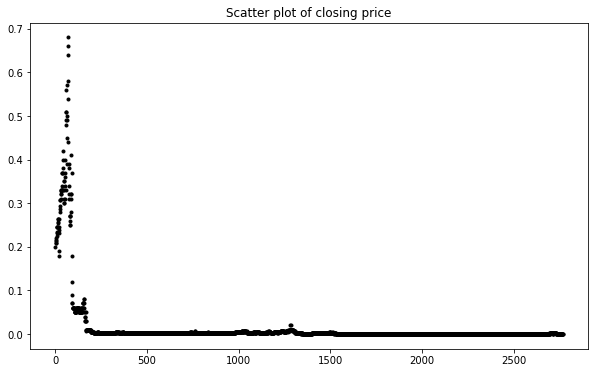

In [30]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

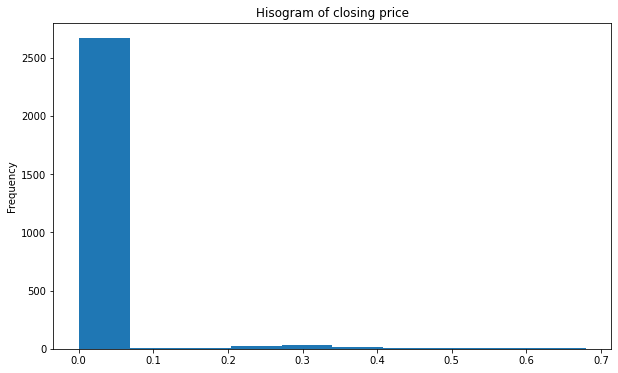

In [31]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

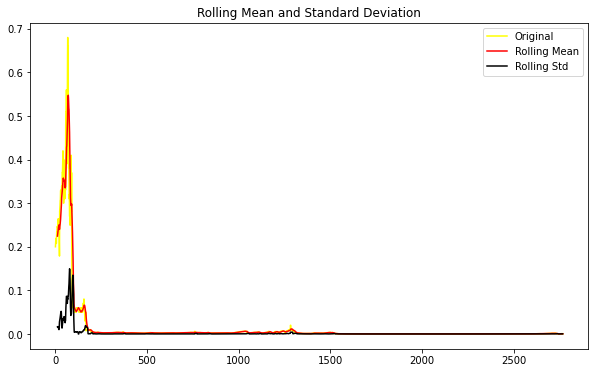

Results of dickey fuller test
Test Statistics               -5.685830e+00
p-value                        8.283862e-07
No. of lags used               2.800000e+01
Number of observations used    2.739000e+03
critical value (1%)           -3.432740e+00
critical value (5%)           -2.862596e+00
critical value (10%)          -2.567332e+00
dtype: float64


In [32]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

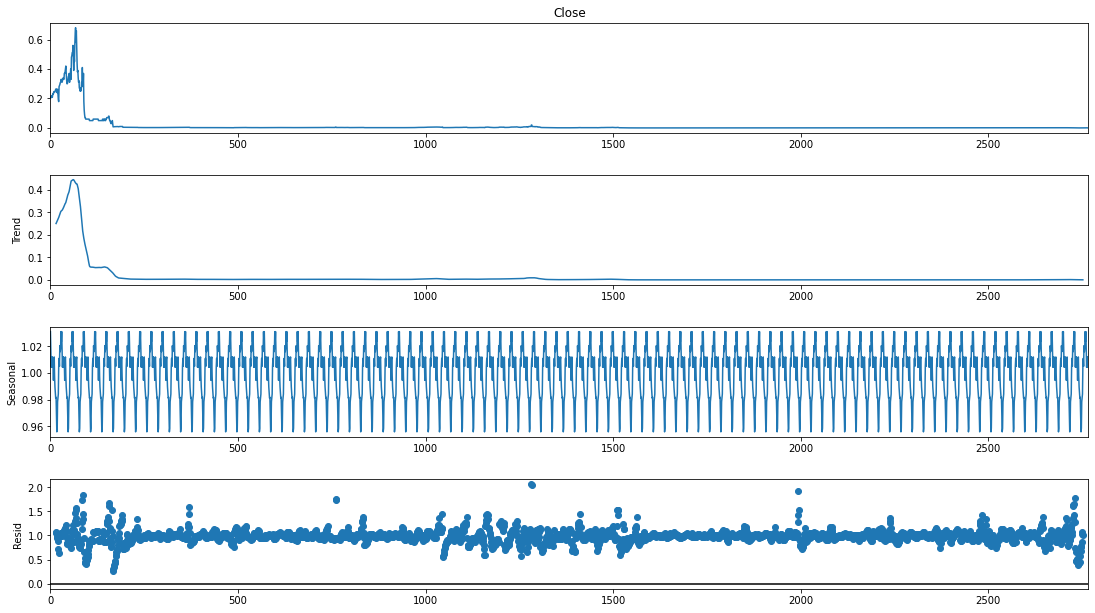

In [33]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


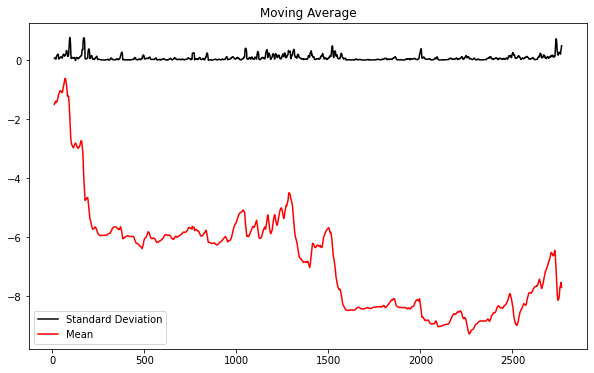

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

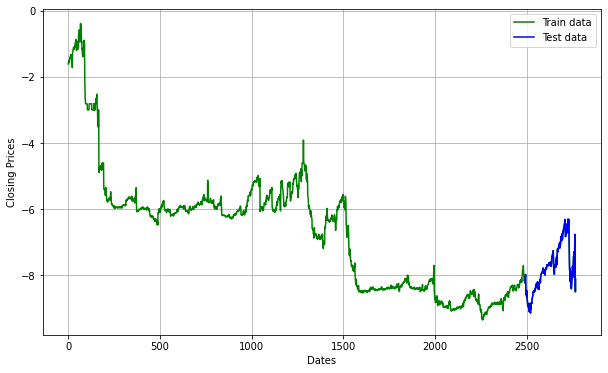

In [35]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [36]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5302.297, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5300.674, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5300.726, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5301.789, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5310.343, Time=2.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5315.692, Time=4.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5307.632, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5316.213, Time=4.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5314.741, Time=2.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5314.434, Time=5.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5318.337, Time=4.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5314.996, Time=2.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5319.016, Time=3.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5314.877, Time=1.35 sec
 ARIMA(3,1,3)(0,0,0

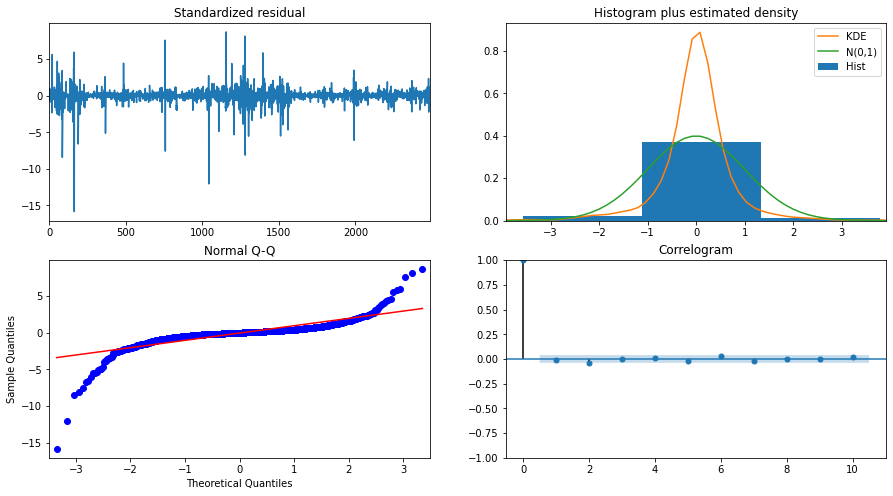

In [37]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [38]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2487
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2666.218
Method:                       css-mle   S.D. of innovations              0.083
Date:                Thu, 05 Aug 2021   AIC                          -5318.436
Time:                        06:16:55   BIC                          -5277.704
Sample:                             1   HQIC                         -5303.645
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0026      0.002     -1.564      0.118      -0.006       0.001
ar.L1.D.Close    -0.6051      0.186     -3.258      0.001      -0.969      -0.241
ar.L2.D.Close    -0.5759      0.135     

In [39]:
# Forecast

fc, se, conf = fitted.forecast(277, alpha=0.05)  # 95% confidence

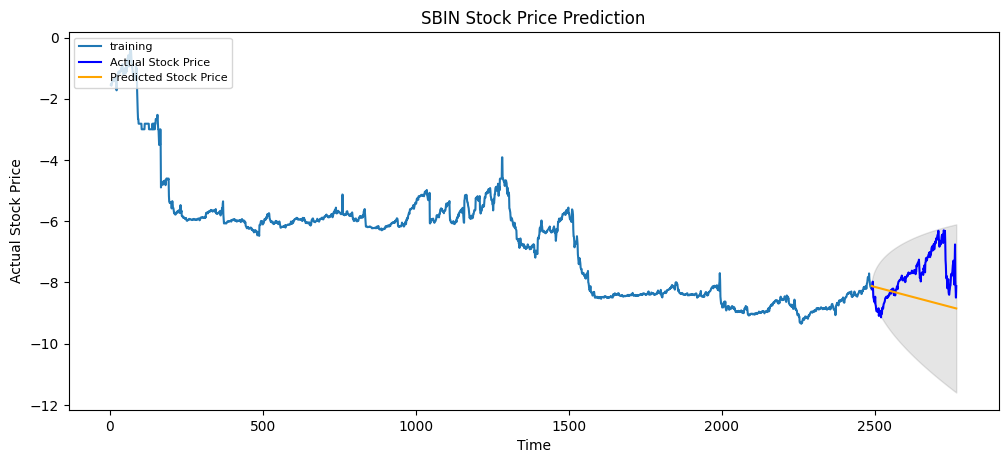

In [40]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SBIN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Animation

In [41]:
def clean_df(name, coin_name) : 
    name = name.rename( 
    columns={
            "Open*" : "Open",
            "Close**" : "Close", 
            "Market Cap" : "Market_Cap" 
        }
    )

    # cleaning values
    name_arr = []
    for i in range(len(name)) :
        dateArr = name.Date[i].split(' ') # split the date into 3 parts 

        if (dateArr[0] == 'Mar') and (dateArr[1] == '15,'):  
            name.Date[i] = dateArr[2] + '.1' # we consider 4 quarters --> if the date is 15 we keep
        elif (dateArr[0] == 'Jun') and (dateArr[1] == '15,') :   
            name.Date[i] = dateArr[2] + '.2'
        elif (dateArr[0] == 'Sep') and (dateArr[1] == '15,'):
            name.Date[i] = dateArr[2] + '.3'
        elif (dateArr[0] == 'Dec') and (dateArr[1] == '15,'):   
            name.Date[i] = dateArr[2] + '.4'
        else :
            name.drop(index = i, inplace = True ) # else we drop 

    # proceed cleaning the new df
    for i in name.index : 
        name_arr.append(coin_name)
        name.Close[i] = name.Close[i][1:]
        name.Volume[i] = name.Volume[i][1:]
        name.Market_Cap[i] = name.Market_Cap[i][1:]
        if name.High[i][0] == "$" : 
            name.High[i] = name.High[i][1:]
        if name.Open[i][0] == "$" : 
            name.Open[i] = name.Open[i][1:]
        if name.Low[i][0] == "$" : 
            name.Low[i] = name.Low[i][1:]
        volume_series = name.Volume.str.split(',')    
        Market_Cap_series = name.Market_Cap.str.split(',')
        name.Volume[i] = join(volume_series[i])
        name.Market_Cap[i] = join(Market_Cap_series[i])

        # for some coins the price is more 
        # so we again split by
        try : 
            Close_series = name.Close.str.split(',')    
            name.Close[i] = join(Close_series[i])
            Open_series = name.Open.str.split(',')    
            name.Open[i] = join(Open_series[i])
            High_series = name.High.str.split(',')    
            name.High[i] = join(High_series[i])
            Low_series = name.Low.str.split(',')    
            name.Low[i] = join(Low_series[i])

        # if doesn't work then there is no comma 
        except : 
            pass # so we pass 

    name['name'] = name_arr 
    name.Date = name.Date.astype(float) # we consider the quarter years as float
    name.Open = name.Open.astype(float)
    name.High = name.High.astype(float)
    name.Low = name.Low.astype(float)
    name.Close = name.Close.astype(float)
    name.Volume = name.Volume.astype(int)
    name.Market_Cap = name.Market_Cap.astype(int)

    # now we add the price col
    price = []
    for i in name.index : 
        price_val = (name.High[i] + name.Low[i])/2
        price.append(price_val)

    name['Price'] = price

    return name 

In [42]:
Binance = pd.read_csv("Binance - Sheet1.csv")
Binance = clean_df(Binance, "Binance")
# Binance

In [43]:
Bitcoin = pd.read_csv("Bitcoin - Sheet1.csv")
Bitcoin = clean_df(Bitcoin, "Bitcoin")
# Bitcoin

In [44]:
Cardano = pd.read_csv("Cardano - Sheet1.csv")
Cardano = clean_df(Cardano, "Cardano")

In [45]:
Dogecoin = pd.read_csv("Dogecoin - Sheet1.csv")
Dogecoin = clean_df(Dogecoin, "Dogecoin")

In [46]:
Ethereum = pd.read_csv("Ethereum - Sheet1.csv")
Ethereum = clean_df(Ethereum, "Ethereum")

In [47]:
Litecoin = pd.read_csv("Litecoin - Sheet1.csv")
Litecoin = clean_df(Litecoin, "Litecoin")

In [48]:
# allCoins = Litecoin.append(Ethereum, ignore_index = True)
allCoins = Litecoin
allCoins = allCoins.append(Dogecoin, ignore_index = True)
allCoins = allCoins.append(Cardano, ignore_index = True)
# allCoins = allCoins.append(Bitcoin, ignore_index = True)
allCoins = allCoins.append(Binance, ignore_index = True)
for i in allCoins.index : 
    if allCoins.Date[i] < 2017.3 : 
        allCoins.drop(index = i, inplace= True)
allCoins.sort_values(by = "Date", inplace = True)
allCoins

,Date,Open,High,Low,Close,Volume,Market_Cap,name,Price
89,2017.3,0.680000,0.850000,0.530000,0.800000,4625680,79970900,Binance,0.690000
74,2017.3,0.680000,0.850000,0.530000,0.800000,4625680,79970900,Cardano,0.690000
44,2017.3,0.000852,0.000950,0.000626,0.000865,21413000,96132679,Dogecoin,0.000788
13,2017.3,41.690000,50.650000,32.030000,48.210000,1554339968,2552770743,Litecoin,41.340000
73,2017.4,0.230000,0.230000,0.190000,0.210000,207311008,5534573967,Cardano,0.210000
88,2017.4,3.160000,4.410000,3.140000,4.000000,52745900,395674796,Binance,3.775000
12,2017.4,280.970000,316.410000,251.220000,299.780000,2599940096,16284702205,Litecoin,283.815000
43,2017.4,0.003670,0.003809,0.003483,0.003762,19043800,422678524,Dogecoin,0.003646
11,2018.1,161.200000,167.330000,151.480000,164.480000,564609024,9152161117,Litecoin,159.405000
72,2018.1,0.200000,0.200000,0.170000,0.190000,204232992,4814890343,Cardano,0.185000


In [49]:
print(allCoins.Price.max())
print(allCoins.Price.min())

283.815
0.0007878


In [50]:
print(allCoins.Market_Cap.max())
print(allCoins.Market_Cap.min())

39353447071
79970900


In [51]:
fig = px.scatter(allCoins, x="Market_Cap", y="Price", animation_frame="Date", size="Volume", color = "name", size_max=55,
           range_x=[50000000, 40000000000], range_y=[0,290])
update_layout("Animation of Volume vs Market Cap vs Price of Popular Alt coins over each quarter", "Market Cap", "Price")

In [52]:
fig = px.bar(allCoins, x="name", y="Market_Cap", color="name", animation_frame="Date", range_y=[10000000, 40000000000])
update_layout("Growing Market Cap of Popular Alt coins over each quarter", "Name", "Market Cap")

## wordart 

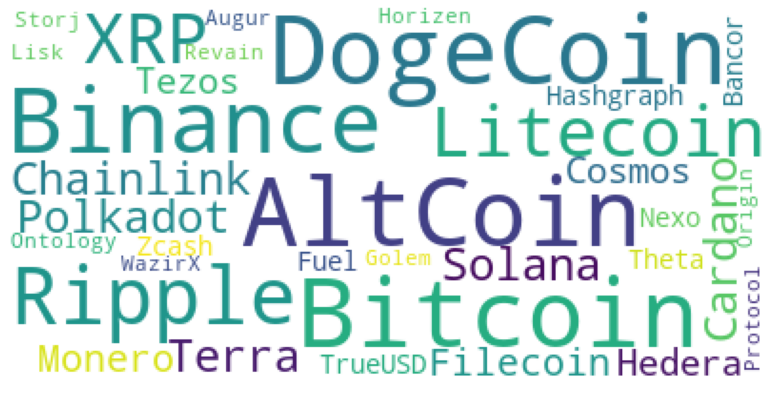

In [53]:
crypto = ["Bitcoin", "AltCoin", "DogeCoin", "Binance", "Ripple", "Litecoin", "XRP", "Chainlink", "Polkadot", "Cardano",
          "Solana", "Terra", "Filecoin", "Monero", "Cosmos", "Tezos", "Hedera Hashgraph", "Theta Fuel", "Zcash", "TrueUSD",
          "Nexo", "Bancor", "Ontology","Horizen", "Revain", "Lisk", "Golem", "WazirX", "Storj","Augur", "Origin Protocol"]
wordCloud = WordCloud(
    background_color='white',
    max_font_size = 50).generate(' '.join(crypto))

plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(wordCloud)
plt.show()

## final datasets 

In [54]:
df.to_csv('Doge_project.csv', encoding='utf-8', index= False)

In [55]:
describe = df.describe()
describe.to_csv('describe.csv', encoding='utf-8', index= False)

In [56]:
!pip freeze requirements.txt

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.0
chardet==3.0.4
charset-normalizer==2.0.2
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3
d